# Import Libaries

In [53]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SubsetRandomSampler, random_split

from pinn_loss import loss_fn_data, l1_regularization, pde_loss, boundary_loss, ic_loss, accuracy
from Input_vec_gen import input_gen, temp_data_gen, st_gen, meshgen, input_3gen
from Datagen import sim1d


# Generate Data

In [54]:
## Load Data 

In [55]:
L1 = sim1d(rho_l=2460.0, rho_s=2710.0, k_l=104.0, k_s= 96.2, cp_l=1245.3, cp_s=963.0, \
            t_surr=298.0, L_fusion=389000, temp_init=913.0, htc_l=10.0,htc_r= 12.0, length =15.0e-3)
                
L2 = sim1d(rho_l=2460.0, rho_s=2710.0, k_l=104.0, k_s= 96.2, cp_l=1245.3, cp_s=963.0, \
            t_surr=298.0, L_fusion=389000, temp_init=913.0, htc_l=12.0,htc_r= 12.0, length =15.0e-3)
L3 = sim1d(rho_l=2460.0, rho_s=2710.0, k_l=104.0, k_s= 96.2, cp_l=1245.3, cp_s=963.0, 
               t_surr=298.0, L_fusion=389000, temp_init=913.0, htc_l=15.0,htc_r= 12.0, length =15.0e-3)          



Stable
Stable
Stable


## Prepare the input and output vectors

In [56]:
length = 15.0e-3 # length of the rod
time_end =40 # end time of the simulation
htc_l_1,htc_l_2,htc_l_3 = 10.0,12.0,15.0 # htc values for the 3 simulations

# Extract the temperature, space and time vectors from the simulation data
T1,space_1,time_1 = L1[0],L1[1],L1[2] # 1st element is the temperature matrix, 2nd is the space vector, 3rd is the time vector
T2,space_2,time_2 = L2[0],L2[1],L2[2]
T3,space_3,time_3 = L3[0],L3[1],L3[2]

Temp_1,space_a1, time_a1 = np.array(T1),np.array(space_1),np.array(time_1)
Temp_2,space_a2, time_a2 = np.array(T2),np.array(space_2),np.array(time_2)
Temp_3,space_a3, time_a3 = np.array(T3),np.array(space_3),np.array(time_3)

# generate htc_l values





In [57]:
scaler = StandardScaler()

# Normalize the data

Temp_1n,Temp_2n, Temp_3n = scaler.fit_transform(Temp_1),scaler.fit_transform(Temp_2),scaler.fit_transform(Temp_3)
Space_1n,Space_2n, Space_3n = scaler.fit_transform(space_a1.reshape(-1,1)),scaler.fit_transform(space_a2.reshape(-1,1)),scaler.fit_transform(space_a3.reshape(-1,1))
Time_1n,Time_2n, Time_3n = scaler.fit_transform(time_a1.reshape(-1,1)),scaler.fit_transform(time_a2.reshape(-1,1)),scaler.fit_transform(time_a3.reshape(-1,1))

print(Temp_1n.shape,Space_1n.shape,Time_1n.shape)


(31470, 50) (50, 1) (31470, 1)


## standardize outputs

In [58]:
Temp_1_pde,Temp_1_ic,Temp_1_bc_l,Temp_1_bc_r = temp_data_gen(Temp_1n,Space_1n,Time_1n)
Temp_2_pde,Temp_2_ic,Temp_2_bc_l,Temp_2_bc_r = temp_data_gen(Temp_2n,Space_2n,Time_2n)
Temp_3_pde,Temp_3_ic,Temp_3_bc_l,Temp_3_bc_r = temp_data_gen(Temp_3n,Space_3n,Time_3n)



Temp_1n_tr,Temp_2n_tr,Temp_3n_tr = Temp_1n.flatten(),Temp_2n.flatten(),Temp_3n.flatten()
Temp_all = np.concatenate((Temp_1n_tr,Temp_2n_tr,Temp_3n_tr))
print(Temp_all.shape)
Temp_1pde_tr,Temp_2pde_tr,Temp_3pde_tr = Temp_1_pde.flatten(),Temp_2_pde.flatten(),Temp_3_pde.flatten()
Temp_pde_all = np.concatenate((Temp_1pde_tr,Temp_2pde_tr,Temp_3pde_tr))


Temp_1ic_tr,Temp_2ic_tr,Temp_3ic_tr = Temp_1_ic.flatten(),Temp_2_ic.flatten(),Temp_3_ic.flatten()
Temp_ic_all = np.concatenate((Temp_1ic_tr,Temp_2ic_tr,Temp_3ic_tr))


Temp_1bcl_tr,Temp_2bcl_tr,Temp_3bcl_tr = Temp_1_bc_l.flatten(),Temp_2_bc_l.flatten(),Temp_3_bc_l.flatten()
Temp_bcl_all = np.concatenate((Temp_1bcl_tr,Temp_2bcl_tr,Temp_3bcl_tr))


Temp_1bcr_tr,Temp_2bcr_tr,Temp_3bcr_tr = Temp_1_bc_r.flatten(),Temp_2_bc_r.flatten(),Temp_3_bc_r.flatten()
Temp_bcr_all = np.concatenate((Temp_1bcr_tr,Temp_2bcr_tr,Temp_3bcr_tr))




(4720500,)


Generate input vector

## Generate htc inputs

In [59]:
sp_pde_1,sp_ic_1,sp_bc_l_1,sp_bc_r_1 = st_gen(Space_1n,Time_1n)[0],st_gen(Space_1n,Time_1n)[1],\
                                        st_gen(Space_1n,Time_1n)[2],st_gen(Space_1n,Time_1n)[3]
t_pde_1,t_ic_1,t_bc_l_1,t_bc_r_1 = st_gen(Space_1n,Time_1n)[4],st_gen(Space_1n,Time_1n)[5],\
                                    st_gen(Space_1n,Time_1n)[6],st_gen(Space_1n,Time_1n)[7]

print(sp_pde_1.shape,sp_ic_1.shape,sp_bc_l_1.shape,sp_bc_r_1.shape)
print(t_pde_1.shape,t_ic_1.shape,t_bc_l_1.shape,t_bc_r_1.shape)

(31469, 48) (50,) (31470,) (31470,)
(31469, 48) (50,) (31470,) (31470,)


## Region 1

In [60]:
sp_pdtr_1 ,t_pdtr_1 = meshgen(sp_pde_1,t_pde_1)
htc_lpde_1 = np.ones(sp_pdtr_1.shape)* htc_l_1
inp_pde_1 = input_3gen(sp_pdtr_1,t_pdtr_1,htc_lpde_1)

sp_ic_1,t_ic_1 = meshgen(sp_ic_1,t_ic_1)
htc_ic_l_1 = np.ones(sp_ic_1.shape)*htc_l_1
inp_ic_1 = input_3gen(sp_ic_1,t_ic_1,htc_ic_l_1)

sp_bc_l_1,t_bc_l_1 = meshgen(sp_bc_l_1,t_bc_l_1)
htc_bc_l_1 = np.ones(sp_bc_l_1.shape)*htc_l_1
inp_bc_l_1 = input_3gen(sp_bc_l_1,t_bc_l_1,htc_bc_l_1)

sp_bc_r_1,t_bc_r_1 = meshgen(sp_bc_r_1,t_bc_r_1)
htc_bc_r_1 = np.ones(sp_bc_r_1.shape)*htc_l_1
inp_bc_r_1 = input_3gen(sp_bc_r_1,t_bc_r_1,htc_bc_r_1) 

Space_1n_tr,Time_1n_tr = np.meshgrid(Space_1n,Time_1n)
Space_tr_1,Time_tr_1 = meshgen(Space_1n_tr,Time_1n_tr)
htc_tr_1 = np.ones(Space_tr_1.shape)*htc_l_1
inp_tr_1 = input_3gen(Space_tr_1,Time_tr_1,htc_tr_1)

## Region 2

In [61]:
sp_pdtr_2 ,t_pdtr_2 = meshgen(sp_pde_1,t_pde_1)
htc_lpde_2 = np.ones(sp_pdtr_2.shape)* htc_l_2
inp_pde_2 = input_3gen(sp_pdtr_2,t_pdtr_2,htc_lpde_2)

sp_ic_2,t_ic_2 = meshgen(sp_ic_1,t_ic_1)
htc_ic_l_2 = np.ones(sp_ic_2.shape)*htc_l_2
inp_ic_2 = input_3gen(sp_ic_2,t_ic_2,htc_ic_l_2)

sp_bc_l_2,t_bc_l_2 = meshgen(sp_bc_l_1,t_bc_l_1)
htc_bc_l_2 = np.ones(sp_bc_l_2.shape)*htc_l_2
inp_bc_l_2 = input_3gen(sp_bc_l_2,t_bc_l_2,htc_bc_l_2)

sp_bc_r_2,t_bc_r_2 = meshgen(sp_bc_r_1,t_bc_r_1)
htc_bc_r_2 = np.ones(sp_bc_r_2.shape)*htc_l_2
inp_bc_r_2 = input_3gen(sp_bc_r_2,t_bc_r_2,htc_bc_r_2)

Space_2n_tr,Time_2n_tr = np.meshgrid(Space_2n,Time_2n)
Space_tr_2,Time_tr_2 = meshgen(Space_2n_tr,Time_2n_tr)
htc_tr_2 = np.ones(Space_tr_2.shape)*htc_l_2
inp_tr_2 = input_3gen(Space_tr_2,Time_tr_2,htc_tr_2)



## Region 3

In [62]:
sp_pdtr_3 ,t_pdtr_3 = meshgen(sp_pde_1,t_pde_1)
htc_lpde_3 = np.ones(sp_pdtr_3.shape)* htc_l_3
inp_pde_3 = input_3gen(sp_pdtr_3,t_pdtr_3,htc_lpde_3)

sp_ic_3,t_ic_3 = meshgen(sp_ic_1,t_ic_1)
htc_ic_l_3 = np.ones(sp_ic_3.shape)*htc_l_3
inp_ic_3 = input_3gen(sp_ic_3,t_ic_3,htc_ic_l_3)

sp_bc_l_3,t_bc_l_3 = meshgen(sp_bc_l_1,t_bc_l_1)
htc_bc_l_3 = np.ones(sp_bc_l_3.shape)*htc_l_3
inp_bc_l_3 = input_3gen(sp_bc_l_3,t_bc_l_3,htc_bc_l_3)

sp_bc_r_3,t_bc_r_3 = meshgen(sp_bc_r_1,t_bc_r_1)
htc_bc_r_3 = np.ones(sp_bc_r_3.shape)*htc_l_3
inp_bc_r_3 = input_3gen(sp_bc_r_3,t_bc_r_3,htc_bc_r_3)

Space_3n_tr,Time_3n_tr = np.meshgrid(Space_3n,Time_3n)
Space_tr_3,Time_tr_3 = meshgen(Space_3n_tr,Time_3n_tr)
htc_tr_3 = np.ones(Space_tr_3.shape)*htc_l_3
inp_tr_3 = input_3gen(Space_tr_3,Time_tr_3,htc_tr_3)

print(inp_pde_1.shape,inp_ic_1.shape,inp_bc_l_1.shape,inp_bc_r_1.shape,inp_tr_1.shape)

(1510512, 3) (50, 3) (31470, 3) (31470, 3) (1573500, 3)


## Combining all data

In [63]:
sp_pdtr_all = np.concatenate((sp_pdtr_1,sp_pdtr_2,sp_pdtr_3),axis=0)
t_pdtr_all = np.concatenate((t_pdtr_1,t_pdtr_2,t_pdtr_3),axis=0)
htc_lpde_all = np.concatenate((htc_lpde_1,htc_lpde_2,htc_lpde_3),axis=0)
inp_pde_all = np.concatenate((inp_pde_1,inp_pde_2,inp_pde_3),axis=0)
print(inp_pde_all.shape)
sp_ic_all = np.concatenate((sp_ic_1,sp_ic_2,sp_ic_3),axis=0)
t_ic_all = np.concatenate((t_ic_1,t_ic_2,t_ic_3),axis=0)
htc_ic_l_all = np.concatenate((htc_ic_l_1,htc_ic_l_2,htc_ic_l_3),axis=0)
inp_ic_all = np.concatenate((inp_ic_1,inp_ic_2,inp_ic_3),axis=0)

print(inp_ic_all.shape)
sp_bc_l_all = np.concatenate((sp_bc_l_1,sp_bc_l_2,sp_bc_l_3),axis=0)
t_bc_l_all = np.concatenate((t_bc_l_1,t_bc_l_2,t_bc_l_3),axis=0)
htc_bc_l_all = np.concatenate((htc_bc_l_1,htc_bc_l_2,htc_bc_l_3),axis=0)
inp_bc_l_all = np.concatenate((inp_bc_l_1,inp_bc_l_2,inp_bc_l_3),axis=0)
print(inp_bc_l_all.shape)
sp_bc_r_all = np.concatenate((sp_bc_r_1,sp_bc_r_2,sp_bc_r_3),axis=0)
t_bc_r_all = np.concatenate((t_bc_r_1,t_bc_r_2,t_bc_r_3),axis=0)
htc_bc_r_all = np.concatenate((htc_bc_r_1,htc_bc_r_2,htc_bc_r_3),axis=0)
inp_bc_r_all = np.concatenate((inp_bc_r_1,inp_bc_r_2,inp_bc_r_3),axis=0)
print(inp_bc_r_all.shape)
Space_all_tr = np.concatenate((Space_tr_1,Space_tr_2,Space_tr_3),axis=0)
Time_all_tr = np.concatenate((Time_tr_1,Time_tr_2,Time_tr_3),axis=0)
htc_tr_all = np.concatenate((htc_tr_1,htc_tr_2,htc_tr_3),axis=0)
inp_tr_all = np.concatenate((inp_tr_1,inp_tr_2,inp_tr_3),axis=0)
print(inp_tr_all.shape)


(4531536, 3)
(150, 3)
(94410, 3)
(94410, 3)
(4720500, 3)


# Plot the Analytical Data

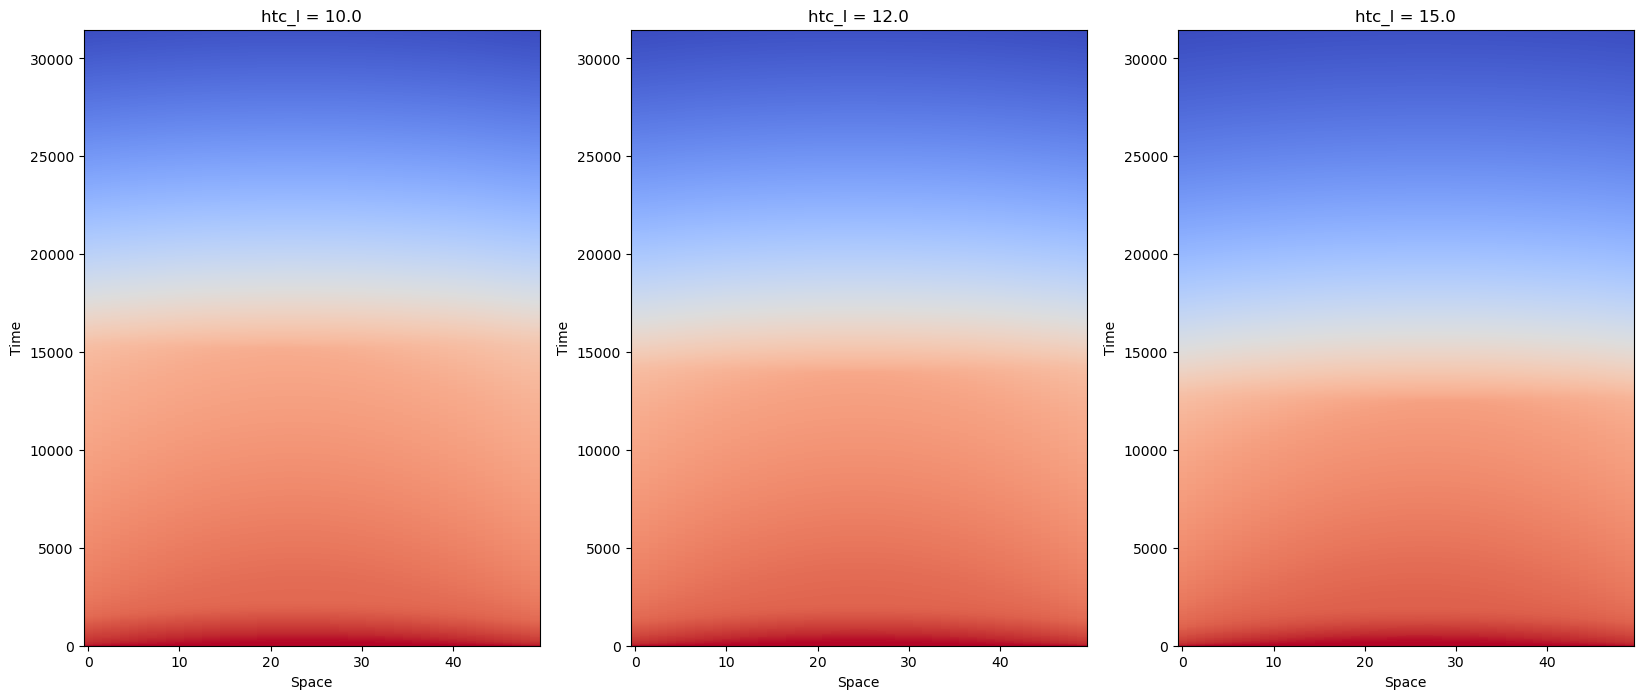

In [64]:
# plt a subplot of the three plots
space_cord, time_cord = np.meshgrid(np.arange(T1.shape[1]), np.arange(T1.shape[0]))
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].pcolormesh(space_cord, time_cord, T1, cmap='coolwarm', shading='auto')
axs[0].set_title('htc_l = 10.0')
axs[0].set_xlabel('Space')
axs[0].set_ylabel('Time')
axs[1].pcolormesh(space_cord, time_cord, T2, cmap='coolwarm', shading='auto')
axs[1].set_title('htc_l = 12.0')
axs[1].set_xlabel('Space')
axs[1].set_ylabel('Time')
axs[2].pcolormesh(space_cord, time_cord, T3, cmap='coolwarm', shading='auto')
axs[2].set_title('htc_l = 15.0')
axs[2].set_xlabel('Space')
axs[2].set_ylabel('Time')
plt.show()


# Data Preparation

# Model Development

In [65]:
# prepare data into interior , boundary and initial condition



# Training & Testing Loop 

# Model Run

# Plots